In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
import random
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

def get_frequency(data):    
    if(data.columns._data[0]=='Time (s)'):        
        time = data['Time (s)']
    
    elif(data.columns._data[0]=='Time(s)'):
        time = data['Time(s)']
    num_entries = len(time)    
    freq = (num_entries-1)/time[num_entries-2]
    return freq

# Butterwort filter
def butterfilt_data(sensordata, fs=200, fc=5):
    sensordata_filt = np.zeros(sensordata.shape)
    w = fc / (fs / 2)
    b,a = signal.butter(fc,w, 'low')
    for i in range (0,3):
        sensordata_filt[:,i] = signal.filtfilt(b,a, sensordata[:,i])  
    return sensordata_filt

#sg filter
def sgfilt_data(sensordata, win_len = 51):
    sensordata_filt = np.zeros(sensordata.shape)
    if not(int(win_len)%2):
        win_len -= 1
    for i in range (0,3):
        sensordata_filt[:,i] = signal.savgol_filter(sensordata[:,i], int(win_len), 2)
    return sensordata_filt

def cut_data(fil_data, freq):
    gyr_abs = np.linalg.norm(fil_data,axis=1)
    #determining the correct height still needs some playing/automation
    #idea: get values of all peaks, take mean as value
    #max_v = np.max(fil_data[:,0])
    srt = np.sort(fil_data[:,0])    
    max_v2 = srt[int(np.floor(0.95*len(srt)))]
    peaks, _ = signal.find_peaks(gyr_abs,height=max_v2/2, distance=freq/2)
    if len(peaks) <= 1: return [],[]
    diff_peaks = np.diff(peaks)
    n = int(np.ceil(len(diff_peaks)/5))
    gap1  = np.argmax(diff_peaks[:n])
    gap2  = np.argmax(diff_peaks[-n:])    
    gap2  = int(gap2 + np.shape(diff_peaks)-n)    
    gyr_cut = fil_data[peaks[gap1+1]:peaks[gap2],:]
    gyr_cut_fil = fil_data
    gyr_cut_fil[0:peaks[gap1],:] = 0    
    gyr_cut_fil[peaks[gap2]:len(fil_data),:] = 0
    return gyr_cut, gyr_cut_fil

def rotate_data(gyr_cut):
    
    pca = PCA(n_components=3)
    rot_data = pca.fit_transform(gyr_cut)
    a = pca.explained_variance_ratio_
    b= pca.components_        
    rot_data = MinMaxScaler().fit_transform(rot_data)       
    return rot_data

#just for testing the inbuilt rotation function, w returns the eigenvectors/principal components
def pca_man(gyr_cut):    
    x1 = np.mean(gyr_cut,axis=0)   
    n = len(gyr_cut)
    for i in range (0,n):
        gyr_cut[i,:] -= x1    
    X = np.transpose(gyr_cut)
    J = np.identity(n)-1/n * np.ones(n)
    C = np.matmul(np.matmul(X,J),np.transpose(np.matmul(X,J)))
    w,v = np.linalg.eig(C)
    
def sample_data(data,freq) :
    srt = np.sort(data[:,0])    
    max_v2 = srt[int(np.floor(0.95*len(srt)))]
    peaks, _ = signal.find_peaks(data[:,0],height = max_v2 * 0.9, distance=freq/2)
    samples = []
    for i in range (0,len(peaks)-1):        
        sample = data[peaks[i]:peaks[i+1]+1,:]
        samples.append(sample)
    return samples

def resample_data(samples, n):
    num_samples = len(samples)       
    for i in range (0,num_samples):
        samples[i] = resample(samples[i],n)
    return samples

def remove_bad_samples(samples,n, min_samples):
    num_samples = len(samples)
    data_per_time = np.empty((num_samples,n))
    for i in range (0,num_samples):
       for j in range (0,n):
        data_per_time[i,j]=samples[i][j,0]
    means = np.median(data_per_time,axis=0)
    not_in_av = np.zeros((num_samples,n),dtype = bool)
    for i in range (0,num_samples):
       for j in range (0,n):
           if(abs(data_per_time[i,j]-means[j]) > 0.2 * means[j]):
               not_in_av[i,j] = 1
    num_wrong = np.count_nonzero(not_in_av,axis=1)
    to_be_removed = np.where(num_wrong > n * 0.3)   
    c = 0
    for i in to_be_removed[0]:        
        del samples[i -c]
        c = c+1
    new_samples = []
    if (len(samples)>=min_samples):
        new_samples = random.sample(samples,min_samples)
    return new_samples

def get_cross_val_lists(path):
    
    folders = os.listdir(path)
    
    subject_list= []
    for folder in folders:     
        subject_list.append(folder[:10].lower())

    unique_subject = list(set(subject_list))

    folds_dict={}
    for k_fold in [2,5,10]:
        n = len(unique_subject)/k_fold
        folds_dict['%s-fold' % k_fold] = {}
        for i in range(0,k_fold,1):
            folds_dict['%s-fold' % k_fold]['fold_%s' % i]= unique_subject[int(i*n):int((i+1)*n)]
    
    return folds_dict

def preprocess_data(folder,data_path):
    gyr_file = data_path + folder + '/Gyroscope.csv'
    
    if 'IMP' in folder.upper(): return 0,0
    
    if os.path.exists(gyr_file):  
        #print(folder)
        data_gyr = pd.read_csv(gyr_file)
        data_gyr.dropna()
        gyr = data_gyr.iloc[1:,1:4].values.astype(float)

        fr = get_frequency(data_gyr)
    
        #filter noise
        gyr_filt = butterfilt_data(gyr,fs = fr)
        #gyr_filt = sgfilt_data(gyr,win_len = np.floor(fr/2))

        #extract motion sequence
        gyr_cut, gyr_cut_fil = cut_data(gyr_filt,fr)
        #rotate
        if(len(gyr_cut)==0): return 0,0
        
        rot_data = rotate_data(gyr_cut)
        #rot_data = pca_man(gyr_cut)

        #find samples
        #this return a list with all samples and their data
        samples = sample_data(rot_data,fr)
        if (not samples): return 0,0
        #rescale samples to same frequency
        n = 100
        samples = resample_data(samples,n)

        #remove bad samples and data with too few samples
        min_samples = 3
        samples = remove_bad_samples(samples,n, min_samples)
        if (not samples): return 0,0
              
            
        if 'DO' in folder.upper():
            labels = np.full(min_samples,0)
        elif 'NO' in folder.upper():
            labels = np.full(min_samples,1)
        elif 'UP' in folder.upper():
            labels = np.full(min_samples,2)
        return samples, labels
    else: 
        return 0,0

def generate_numpy_arrays(fold_dict,data_path):
    folders = os.listdir(data_path)
    os.makedirs('arrays/')
    for k_fold in [2,5,10]:
        
        #accuracy_results = []
        for i in range(k_fold):
            training_subjects= []
            testing_subjects = []

            testing_subjects = fold_dict['%s-fold' % k_fold]['fold_%s'% i]
            print(i)
            for x in range(k_fold):
                if x != i:
                    training_subjects += fold_dict['%s-fold' % k_fold]['fold_%s'% x]
                    print(x)

            train_data = []
            train_labels = []
            test_data = []
            test_labels = []

            for folder in folders:
                if folder[:10].lower() in training_subjects:
                    samples, labels = preprocess_data(folder,data_path) 
                    if samples == 0: continue 
                    train_data.append(samples)
                    train_labels.append(labels)
                elif folder[:10].lower() in testing_subjects:
                    samples, labels = preprocess_data(folder,data_path)
                    if samples == 0: continue
                    test_data.append(samples)
                    test_labels.append(labels)
                else: continue

            training_data = np.concatenate(train_data)
            np.save('arrays/training_data_'+ '%s-fold_' % k_fold+'%s' %i,training_data)
            training_labels = np.concatenate(train_labels)
            np.save('arrays/training_labels_'+ '%s-fold_' % k_fold+'%s' %i,training_labels)
            testing_data = np.concatenate(test_data)
            np.save('arrays/testing_data_'+ '%s-fold_' % k_fold+'%s' %i,testing_data)
            testing_labels = np.concatenate(test_labels)
            np.save('arrays/testing_labels_'+ '%s-fold_' % k_fold+'%s' %i,testing_labels)
            print('Generated and saved arrays for %s-fold cross validation:' % k_fold + 'fold number %s' % i)           

def cross_validation_training(k_fold):
    
    accuracy_results = []
    for i in range(k_fold):
        training_data = np.load('arrays/training_data_'+ '%s-fold_' % k_fold+'%s' %i+'.npy')
        training_labels = np.load('arrays/training_labels_'+ '%s-fold_' % k_fold+'%s' %i+'.npy')
        testing_data = np.load('arrays/testing_data_'+ '%s-fold_' % k_fold+'%s' %i+'.npy')          
        testing_labels = np.load('arrays/testing_labels_'+ '%s-fold_' % k_fold+'%s' %i+'.npy')
        print('Training labels distribution:',np.unique(training_labels, return_index=False, return_inverse=False, return_counts=True, axis=None))
        print('Testing labels distribution:',np.unique(testing_labels, return_index=False, return_inverse=False, return_counts=True, axis=None))

        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(100,3)),
                tf.keras.layers.Dense(10, activation ='relu'),
                tf.keras.layers.Dense(10, activation ='relu'),
                tf.keras.layers.Dense(3, activation ='softmax')
                ])

        #Define early stop
        early_stop = tf.keras.callbacks.EarlyStopping(
                  monitor="val_accuracy",
                  patience=10,
                  verbose=1)


        # Compile model
        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])


        history = model.fit(training_data,training_labels,validation_data=(testing_data,testing_labels), 
                                batch_size = 32,epochs = 50,
                               callbacks=early_stop)

        accuracy_results.append(np.max(history.history['val_accuracy']))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

    print('Best validation accuracy:', np.max(accuracy_results))
    print(accuracy_results)
    print('Mean validation accuracy:', np.mean(accuracy_results))
    return accuracy_results

ModuleNotFoundError: No module named 'packaging'

### You only need to run the following cell once to generate and save the numpy arrays for training

In [2]:
data_path = 'Smartphone1/'
#obtain distribution of subjects per fold
fold_dict = get_cross_val_lists(data_path)
#function that generates and saves the numpy arrays
generate_numpy_arrays(fold_dict,data_path)

NameError: name 'get_cross_val_lists' is not defined

### Training

Training labels distribution: (array([0, 1, 2]), array([192, 279, 210], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([174, 288, 228], dtype=int64))
Epoch 1/50
22/22 [==============================] - 1s 9ms/step - loss: 1.0979 - accuracy: 0.4009 - val_loss: 1.0756 - val_accuracy: 0.4174
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 1.0328 - accuracy: 0.4978 - val_loss: 0.9508 - val_accuracy: 0.5536
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 0.8482 - accuracy: 0.6167 - val_loss: 0.8023 - val_accuracy: 0.5899
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.7467 - accuracy: 0.6461 - val_loss: 0.7419 - val_accuracy: 0.5957
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.7335 - accuracy: 0.6270 - val_loss: 0.7409 - val_accuracy: 0.6029
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.6535 - val_loss: 0.8522 - val_accura

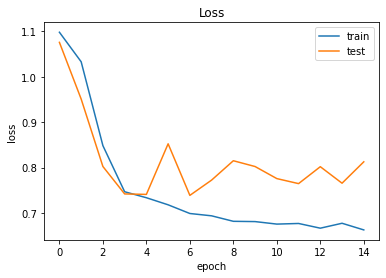

Training labels distribution: (array([0, 1, 2]), array([174, 288, 228], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([192, 279, 210], dtype=int64))
Epoch 1/50
22/22 [==============================] - 1s 21ms/step - loss: 1.0473 - accuracy: 0.3913 - val_loss: 0.9642 - val_accuracy: 0.4537
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.7867 - accuracy: 0.6594 - val_loss: 0.7790 - val_accuracy: 0.5918
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.5642 - accuracy: 0.7478 - val_loss: 0.7641 - val_accuracy: 0.7004
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 0.5119 - accuracy: 0.7681 - val_loss: 0.6774 - val_accuracy: 0.7283
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5080 - accuracy: 0.7681 - val_loss: 0.7493 - val_accuracy: 0.7474
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.4752 - accuracy: 0.7812 - val_loss: 0.6316 - val_accur

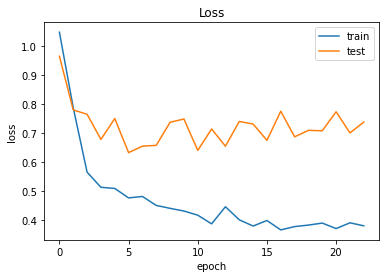

Best validation accuracy: 0.7826725244522095
[0.6028985381126404, 0.7826725244522095]
Mean validation accuracy: 0.6927855312824249
Training labels distribution: (array([0, 1, 2]), array([318, 456, 360], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([ 48, 111,  78], dtype=int64))
Epoch 1/50
36/36 [==============================] - 1s 6ms/step - loss: 1.1052 - accuracy: 0.3801 - val_loss: 1.0645 - val_accuracy: 0.4684
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 1.0880 - accuracy: 0.4021 - val_loss: 1.0611 - val_accuracy: 0.4684
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 1.0880 - accuracy: 0.4021 - val_loss: 1.0625 - val_accuracy: 0.4684
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 1.0884 - accuracy: 0.4021 - val_loss: 1.0608 - val_accuracy: 0.4684
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 1.0877 - accuracy: 0.4021 - val_loss: 1.0610 - val_accuracy: 0.468

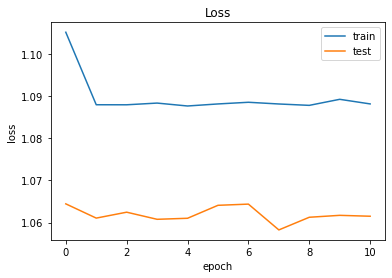

Training labels distribution: (array([0, 1, 2]), array([291, 447, 333], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([ 75, 120, 105], dtype=int64))
Epoch 1/50
34/34 [==============================] - 1s 6ms/step - loss: 1.0462 - accuracy: 0.4164 - val_loss: 0.8636 - val_accuracy: 0.5533
Epoch 2/50
34/34 [==============================] - 0s 2ms/step - loss: 0.7649 - accuracy: 0.6601 - val_loss: 0.5424 - val_accuracy: 0.7667
Epoch 3/50
34/34 [==============================] - 0s 2ms/step - loss: 0.6665 - accuracy: 0.7283 - val_loss: 0.5603 - val_accuracy: 0.7067
Epoch 4/50
34/34 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.7367 - val_loss: 0.4548 - val_accuracy: 0.8100
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.5681 - accuracy: 0.7638 - val_loss: 0.3998 - val_accuracy: 0.8667
Epoch 6/50
34/34 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.7834 - val_loss: 0.4098 - val_accura

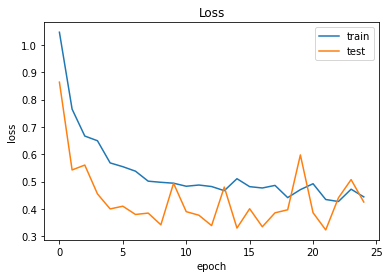

Training labels distribution: (array([0, 1, 2]), array([282, 459, 342], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([ 84, 108,  96], dtype=int64))
Epoch 1/50
34/34 [==============================] - 1s 6ms/step - loss: 0.8924 - accuracy: 0.5836 - val_loss: 0.7264 - val_accuracy: 0.6389
Epoch 2/50
34/34 [==============================] - 0s 2ms/step - loss: 0.5722 - accuracy: 0.7756 - val_loss: 0.7542 - val_accuracy: 0.6597
Epoch 3/50
34/34 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.8070 - val_loss: 0.6612 - val_accuracy: 0.6771
Epoch 4/50
34/34 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.7802 - val_loss: 0.6623 - val_accuracy: 0.6736
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.4959 - accuracy: 0.8153 - val_loss: 0.7173 - val_accuracy: 0.6806
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 0.5058 - accuracy: 0.8006 - val_loss: 0.5718 - val_accura

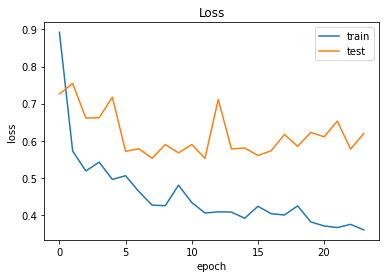

Training labels distribution: (array([0, 1, 2]), array([273, 450, 348], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([ 93, 117,  90], dtype=int64))
Epoch 1/50
34/34 [==============================] - 1s 6ms/step - loss: 1.0035 - accuracy: 0.4678 - val_loss: 0.8653 - val_accuracy: 0.6967
Epoch 2/50
34/34 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.7395 - val_loss: 0.8737 - val_accuracy: 0.7233
Epoch 3/50
34/34 [==============================] - 0s 2ms/step - loss: 0.5370 - accuracy: 0.7591 - val_loss: 0.9051 - val_accuracy: 0.7633
Epoch 4/50
34/34 [==============================] - 0s 2ms/step - loss: 0.4974 - accuracy: 0.7965 - val_loss: 0.9266 - val_accuracy: 0.7600
Epoch 5/50
34/34 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.8039 - val_loss: 0.8798 - val_accuracy: 0.7567
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 0.4976 - accuracy: 0.8021 - val_loss: 0.8339 - val_accura

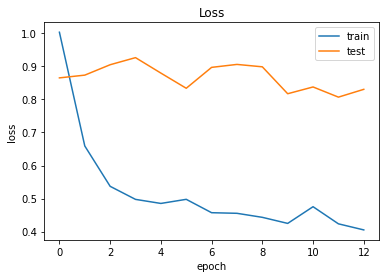

Training labels distribution: (array([0, 1, 2]), array([300, 456, 369], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([ 66, 111,  69], dtype=int64))
Epoch 1/50
36/36 [==============================] - ETA: 11s - loss: 1.3031 - accuracy: 0.312 - 1s 6ms/step - loss: 1.0766 - accuracy: 0.4160 - val_loss: 1.0138 - val_accuracy: 0.4512
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 0.8936 - accuracy: 0.5520 - val_loss: 0.9106 - val_accuracy: 0.5894
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.7670 - accuracy: 0.5804 - val_loss: 0.7240 - val_accuracy: 0.6463
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.7169 - accuracy: 0.6249 - val_loss: 0.7179 - val_accuracy: 0.6341
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.7074 - accuracy: 0.6364 - val_loss: 0.9118 - val_accuracy: 0.5447
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6864 - accu

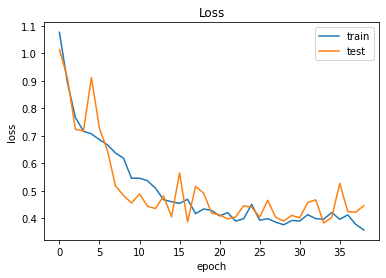

Best validation accuracy: 0.8933333158493042
[0.4683544337749481, 0.8933333158493042, 0.7673611044883728, 0.7633333206176758, 0.8536585569381714]
Mean validation accuracy: 0.7492081463336945
Training labels distribution: (array([0, 1, 2]), array([342, 516, 405], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([24, 51, 33], dtype=int64))
Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 1.0072 - accuracy: 0.5123 - val_loss: 0.8159 - val_accuracy: 0.6574
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.5990 - accuracy: 0.7601 - val_loss: 0.8259 - val_accuracy: 0.6481
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.5375 - accuracy: 0.7846 - val_loss: 0.8925 - val_accuracy: 0.6204
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.4932 - accuracy: 0.8100 - val_loss: 0.8318 - val_accuracy: 0.6111
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.4721 - 

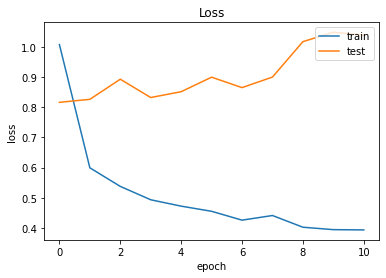

Training labels distribution: (array([0, 1, 2]), array([342, 507, 393], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([24, 60, 45], dtype=int64))
Epoch 1/50
39/39 [==============================] - 1s 5ms/step - loss: 1.0307 - accuracy: 0.4517 - val_loss: 0.9071 - val_accuracy: 0.6744
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7237 - accuracy: 0.6965 - val_loss: 0.5845 - val_accuracy: 0.7054
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5956 - accuracy: 0.7705 - val_loss: 0.6179 - val_accuracy: 0.7287
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5495 - accuracy: 0.7786 - val_loss: 0.5602 - val_accuracy: 0.7364
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5127 - accuracy: 0.7979 - val_loss: 0.5024 - val_accuracy: 0.7442
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5034 - accuracy: 0.7923 - val_loss: 0.5219 - val_accuracy:

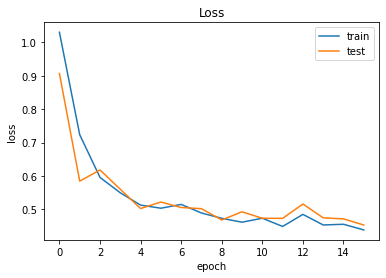

Training labels distribution: (array([0, 1, 2]), array([324, 507, 384], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([42, 60, 54], dtype=int64))
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 1.0145 - accuracy: 0.4626 - val_loss: 0.8027 - val_accuracy: 0.6603
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.7169 - val_loss: 0.5243 - val_accuracy: 0.7500
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7556 - val_loss: 0.4594 - val_accuracy: 0.8718
Epoch 4/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5394 - accuracy: 0.7794 - val_loss: 0.4430 - val_accuracy: 0.8462
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5450 - accuracy: 0.7885 - val_loss: 0.5195 - val_accuracy: 0.7692
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5095 - accuracy: 0.7811 - val_loss: 0.4080 - val_accuracy:

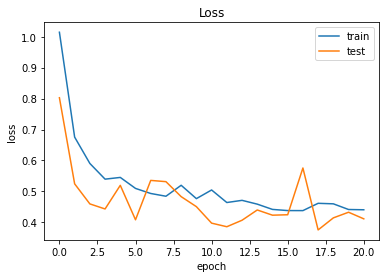

Training labels distribution: (array([0, 1, 2]), array([333, 507, 387], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([33, 60, 51], dtype=int64))
Epoch 1/50
39/39 [==============================] - 1s 12ms/step - loss: 0.9953 - accuracy: 0.4768 - val_loss: 0.7056 - val_accuracy: 0.6111
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7309 - accuracy: 0.6813 - val_loss: 0.4641 - val_accuracy: 0.8681
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.6154 - accuracy: 0.7400 - val_loss: 0.3362 - val_accuracy: 0.9097
Epoch 4/50
39/39 [==============================] - 0s 3ms/step - loss: 0.5925 - accuracy: 0.7522 - val_loss: 0.4263 - val_accuracy: 0.8125
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5601 - accuracy: 0.7694 - val_loss: 0.2683 - val_accuracy: 0.8889
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5625 - accuracy: 0.7588 - val_loss: 0.3069 - val_accuracy

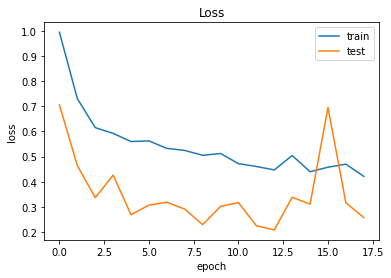

Training labels distribution: (array([0, 1, 2]), array([315, 510, 393], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([51, 57, 45], dtype=int64))
Epoch 1/50
39/39 [==============================] - 1s 6ms/step - loss: 1.0563 - accuracy: 0.4253 - val_loss: 1.0738 - val_accuracy: 0.4052
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.9162 - accuracy: 0.5558 - val_loss: 0.9738 - val_accuracy: 0.6209
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7306 - accuracy: 0.7233 - val_loss: 0.7910 - val_accuracy: 0.7059
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5992 - accuracy: 0.7767 - val_loss: 0.6211 - val_accuracy: 0.7255
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5782 - accuracy: 0.7709 - val_loss: 0.5390 - val_accuracy: 0.7255
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5018 - accuracy: 0.7997 - val_loss: 0.5057 - val_accuracy:

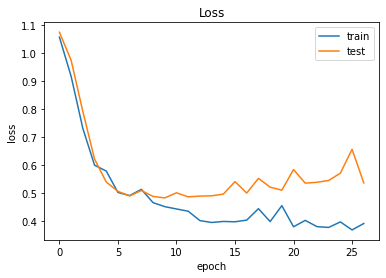

Training labels distribution: (array([0, 1, 2]), array([333, 516, 387], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([33, 51, 51], dtype=int64))
Epoch 1/50
39/39 [==============================] - 1s 6ms/step - loss: 0.9656 - accuracy: 0.4960 - val_loss: 1.1020 - val_accuracy: 0.5704
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7202 - accuracy: 0.6950 - val_loss: 0.5913 - val_accuracy: 0.8000
Epoch 3/50
39/39 [==============================] - 0s 3ms/step - loss: 0.5849 - accuracy: 0.7670 - val_loss: 0.6037 - val_accuracy: 0.7481
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5364 - accuracy: 0.7727 - val_loss: 0.5532 - val_accuracy: 0.7556
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4964 - accuracy: 0.8010 - val_loss: 0.5251 - val_accuracy: 0.7481
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4712 - accuracy: 0.8042 - val_loss: 0.6050 - val_accuracy:

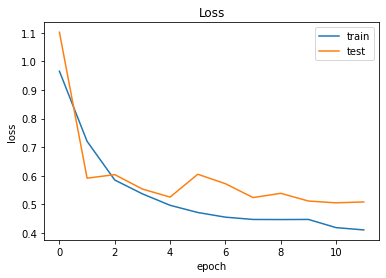

Training labels distribution: (array([0, 1, 2]), array([318, 510, 393], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([48, 57, 45], dtype=int64))
Epoch 1/50
39/39 [==============================] - 1s 7ms/step - loss: 0.9265 - accuracy: 0.5242 - val_loss: 0.8504 - val_accuracy: 0.7200
Epoch 2/50
39/39 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.7551 - val_loss: 0.9212 - val_accuracy: 0.7000
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.7838 - val_loss: 0.9327 - val_accuracy: 0.7067
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5035 - accuracy: 0.8026 - val_loss: 0.8197 - val_accuracy: 0.7400
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4664 - accuracy: 0.8075 - val_loss: 0.8369 - val_accuracy: 0.7533
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.8206 - val_loss: 0.8655 - val_accuracy:

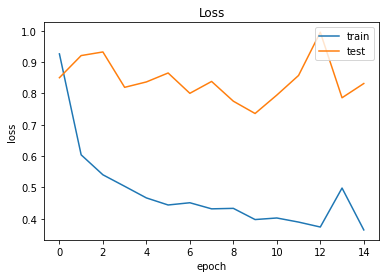

Training labels distribution: (array([0, 1, 2]), array([321, 507, 393], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([45, 60, 45], dtype=int64))
Epoch 1/50
39/39 [==============================] - 1s 5ms/step - loss: 0.9485 - accuracy: 0.5602 - val_loss: 0.8457 - val_accuracy: 0.5667
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7355 - accuracy: 0.6126 - val_loss: 0.8004 - val_accuracy: 0.6333
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7101 - accuracy: 0.6216 - val_loss: 0.8196 - val_accuracy: 0.6267
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.6282 - val_loss: 0.8322 - val_accuracy: 0.6200
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.6241 - val_loss: 0.9568 - val_accuracy: 0.5400
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.8134 - accuracy: 0.5749 - val_loss: 0.8280 - val_accuracy:

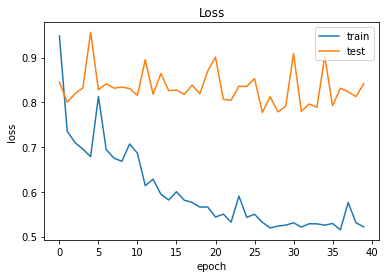

Training labels distribution: (array([0, 1, 2]), array([327, 510, 402], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([39, 57, 36], dtype=int64))
Epoch 1/50
39/39 [==============================] - 1s 5ms/step - loss: 0.9916 - accuracy: 0.4972 - val_loss: 0.7766 - val_accuracy: 0.6136
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7139 - accuracy: 0.7207 - val_loss: 0.7387 - val_accuracy: 0.6439
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.7482 - val_loss: 0.4707 - val_accuracy: 0.8409
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5133 - accuracy: 0.7869 - val_loss: 0.4626 - val_accuracy: 0.8258
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5412 - accuracy: 0.7716 - val_loss: 0.5272 - val_accuracy: 0.7576
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.7910 - val_loss: 0.4280 - val_accuracy:

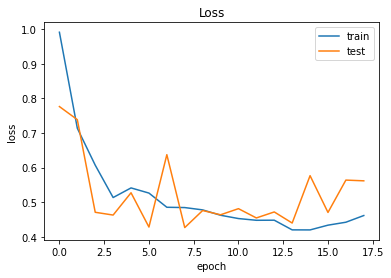

Training labels distribution: (array([0, 1, 2]), array([339, 513, 405], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([27, 54, 33], dtype=int64))
Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 0.9888 - accuracy: 0.4590 - val_loss: 0.8782 - val_accuracy: 0.5965
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.8642 - accuracy: 0.5776 - val_loss: 0.8274 - val_accuracy: 0.6404
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.7794 - accuracy: 0.6380 - val_loss: 0.7490 - val_accuracy: 0.6316
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.7372 - accuracy: 0.6842 - val_loss: 0.9574 - val_accuracy: 0.5702
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.7497 - accuracy: 0.6277 - val_loss: 0.7420 - val_accuracy: 0.6667
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.7009 - accuracy: 0.7033 - val_loss: 0.6188 - val_accuracy:

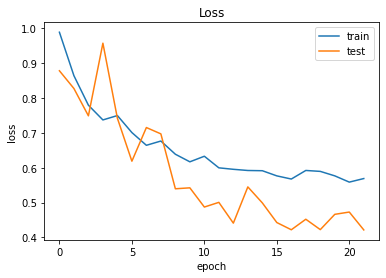

Best validation accuracy: 0.9236111044883728
[0.6574074029922485, 0.7751938104629517, 0.8782051205635071, 0.9236111044883728, 0.8496732115745544, 0.800000011920929, 0.753333330154419, 0.746666669845581, 0.8636363744735718, 0.9035087823867798]
Mean validation accuracy: 0.8151235818862915
Mean accuracy for 2-fold: 0.6927855312824249
Mean accuracy for 5-fold: 0.7492081463336945
Mean accuracy for 10-fold: 0.8151235818862915


In [34]:
#In order to change the parameters you need to go to the cross_validation_training function
#There you can and should change the following parameters:
#number of neurons in each layer, number of layers, activation functions, patience on the early stopping,
#learning_rate, batch_size, epochs
#The relevant value for the accuracy of a model(or whatever metrics you use) is the mean value between all folds.
accuracy_results_2fold = cross_validation_training(k_fold=2)
accuracy_results_5fold = cross_validation_training(k_fold=5)
accuracy_results_10fold = cross_validation_training(k_fold=10)
print('Mean accuracy for 2-fold: %s' % np.mean(accuracy_results_2fold))
print('Mean accuracy for 5-fold: %s' % np.mean(accuracy_results_5fold))
print('Mean accuracy for 10-fold: %s' % np.mean(accuracy_results_10fold))

Training labels distribution: (array([0, 1, 2]), array([192, 279, 210], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([174, 288, 228], dtype=int64))
Epoch 1/50
22/22 [==============================] - 1s 11ms/step - loss: 1.0744 - accuracy: 0.3789 - val_loss: 1.0007 - val_accuracy: 0.4841
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.9092 - accuracy: 0.5653 - val_loss: 0.8134 - val_accuracy: 0.6971
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.7386 - val_loss: 0.5985 - val_accuracy: 0.7435
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5838 - accuracy: 0.7915 - val_loss: 0.5658 - val_accuracy: 0.7638
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5431 - accuracy: 0.7944 - val_loss: 0.5565 - val_accuracy: 0.7565
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5213 - accuracy: 0.8120 - val_loss: 0.5764 - val_accur

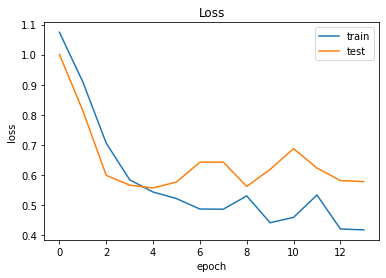

Training labels distribution: (array([0, 1, 2]), array([174, 288, 228], dtype=int64))
Testing labels distribution: (array([0, 1, 2]), array([192, 279, 210], dtype=int64))
Epoch 1/50
22/22 [==============================] - 1s 11ms/step - loss: 1.0303 - accuracy: 0.3957 - val_loss: 0.9871 - val_accuracy: 0.4097
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.9025 - accuracy: 0.5623 - val_loss: 0.9100 - val_accuracy: 0.4611
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.8311 - accuracy: 0.6014 - val_loss: 0.8624 - val_accuracy: 0.6623
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.7705 - accuracy: 0.6522 - val_loss: 0.8061 - val_accuracy: 0.7298
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.7250 - accuracy: 0.7058 - val_loss: 0.7821 - val_accuracy: 0.7533
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.7029 - val_loss: 0.8609 - val_accur

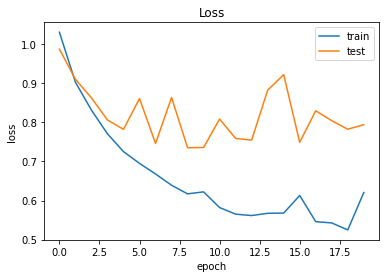

Best validation accuracy: 0.781204104423523
[0.7637681365013123, 0.781204104423523]
Mean validation accuracy: 0.7724861204624176
Mean accuracy for 2-fold: 0.7724861204624176


In [35]:
#Do one at a time if you prefer
accuracy_results_2fold = cross_validation_training(k_fold=2)
print('Mean accuracy for 2-fold: %s' % np.mean(accuracy_results_2fold))